In [1]:
import Pkg
Pkg.activate("../../../FinancialPlanner")

  Activating project at `c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner`


In [2]:
using Revise
using LinearAlgebra
using Distributions
using Random
using StatsPlots
using PDMats
using StatsBase
using Base.Iterators
using DataFrames, TimeSeries, XLSX
using PrettyTables

In [3]:
includet("../VARs/utils.jl")
includet("../VARs/VAR_OLS.jl")

In [8]:
df = DataFrame(XLSX.readtable("../../data/usa_macro_data.xlsx", "Quarterly", infer_eltypes=true))
data_source = collapse(TimeArray(df; timestamp = :observation_date), Dates.quarter, first)

display(returns_summarystats(data_source, 1)) 

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
A939RX0Q048SBEA,14971.2,68696.0,39698.0,53922.8,17584.0,0.1619,26344.5,0.9892,-1.2465,2.6516,39389.5
GDPDEF,33.0847,125.532,56.0893,84.6945,13.42,0.2146,20.9215,0.9892,-1.2062,1.6953,56.109
TB3MS,3.0645,15.05,4.1755,5.6525,0.01,0.828,1.78,0.9743,0.9389,1.3625,4.105
GS10,2.894,14.85,5.5547,7.35,0.65,0.8787,3.4925,0.9862,0.5021,1.9194,4.835
Price_10Y,1689.31,5588.73,1582.8,2728.29,103.357,0.8445,167.763,0.9917,-0.774,0.937,709.15
Stock_Price,1148.73,5446.68,866.909,1275.08,24.39,1.8788,92.9475,0.968,3.1993,0.7547,303.95
Dividend,18.1073,71.9758,16.6295,22.5067,1.4167,1.5043,3.1217,0.982,1.3175,0.9184,9.7683
E,47.1315,197.883,39.71,57.8683,2.4567,1.6451,5.7475,0.9756,2.1096,0.8425,16.5717
CAPE,8.0844,43.2083,20.7779,25.9245,6.6434,0.4983,15.1349,0.9784,-0.1175,2.5701,20.3851


nothing

In [27]:
data_source[:GDPDEF]

286×1 TimeArray{Float64, 1, Date, Vector{Float64}} 1953-04-01 to 2024-07-01
┌────────────┬─────────┐
│            │ GDPDEF  │
├────────────┼─────────┤
│ 1953-04-01 │   13.42 │
│ 1953-07-01 │  13.476 │
│ 1953-10-01 │  13.501 │
│ 1954-01-01 │  13.544 │
│ 1954-04-01 │  13.556 │
│ 1954-07-01 │  13.574 │
│ 1954-10-01 │  13.611 │
│ 1955-01-01 │  13.675 │
│     ⋮      │    ⋮    │
│ 2023-01-01 │ 121.251 │
│ 2023-04-01 │ 121.804 │
│ 2023-07-01 │ 122.768 │
│ 2023-10-01 │ 123.241 │
│ 2024-01-01 │ 124.163 │
│ 2024-04-01 │ 124.943 │
│ 2024-07-01 │ 125.532 │
└────────────┴─────────┘
        271 rows omitted

In [49]:
freq = 1

cpi = (log.(data_source[:GDPDEF]) .- lag(log.(data_source[:GDPDEF]),4)) .* 100 
gdp = (log.(data_source[:A939RX0Q048SBEA]) .- lag(log.(data_source[:A939RX0Q048SBEA]),4)) .* 100 
sr = (data_source[:TB3MS]) .- cpi
term = (data_source[:GS10]) .- (data_source[:TB3MS])
Δd = (log.(data_source[:Dividend]) .- lag(log.(data_source[:Dividend]),4)) .* 100 .- cpi
dy = round.((log.(data_source[:Dividend]) .- log.(data_source[:Stock_Price])), digits=2)

data= merge(gdp, cpi, sr, term, Δd, dy)

start = Date(1985, 01,01)
end_d = Date(2024, 12, 31)
s_data = to(from(data, start),end_d)

display(returns_summarystats(s_data, freq)) 
display(cor(values(s_data)))



,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
A939RX0Q048SBEA_A939RX0Q048SBEA,1.9201,11.4109,1.7029,2.8079,-8.2584,-0.8873,1.0132,0.6838,8.7904,0.8869,1.8675
GDPDEF_GDPDEF,1.1793,7.4709,2.3319,2.7695,0.1153,1.7607,1.6577,0.9458,4.7314,1.9773,2.0521
TB3MS_GDPDEF_GDPDEF,2.4086,4.7148,0.8506,3.1995,-6.4539,-0.4414,-0.9039,0.9656,-0.1208,0.3531,0.6274
GS10_TB3MS,1.2048,3.7,1.6401,2.655,-1.48,-0.299,0.74,0.9159,-0.6069,1.3614,1.65
Dividend_Dividend_GDPDEF_GDPDEF,6.226,14.51,3.3882,7.6768,-23.0477,-1.3765,0.8797,0.9518,3.7815,0.5442,3.5987
Dividend_Stock_Price,0.3208,-3.17,-3.8762,-3.595,-4.5,0.3421,-4.095,0.9538,-0.6936,-12.0821,-3.93


nothing

6×6 Matrix{Float64}:
  1.0        0.262863    0.122466    -0.101136   0.107813    -0.174588
  0.262863   1.0        -0.143025    -0.217046   0.0864797    0.0701478
  0.122466  -0.143025    1.0         -0.23493   -0.00638544   0.355108
 -0.101136  -0.217046   -0.23493      1.0       -0.262198     0.402236
  0.107813   0.0864797  -0.00638544  -0.262198   1.0          0.0804026
 -0.174588   0.0701478   0.355108     0.402236   0.0804026    1.0

In [47]:
s_data

159×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1985-01-01 to 2024-07-01
┌────────────┬─────────────────────────────────┬───────────────┬────────────────
│            │ A939RX0Q048SBEA_A939RX0Q048SBEA │ GDPDEF_GDPDEF │ TB3MS_GDPDEF_ ⋯
├────────────┼─────────────────────────────────┼───────────────┼────────────────
│ 1985-01-01 │                         3.57999 │       3.46524 │             4 ⋯
│ 1985-04-01 │                         2.73506 │       3.25498 │             4 ⋯
│ 1985-07-01 │                         3.27796 │        2.9721 │               ⋯
│ 1985-10-01 │                         3.19322 │       2.78471 │             4 ⋯
│ 1986-01-01 │                         3.14693 │       2.29697 │             4 ⋯
│ 1986-04-01 │                         2.71969 │       2.03333 │             4 ⋯
│ 1986-07-01 │                         2.16603 │       1.84041 │             3 ⋯
│ 1986-10-01 │                          1.9716 │       1.82644 │             3 ⋯
│     ⋮      │                ⋮  

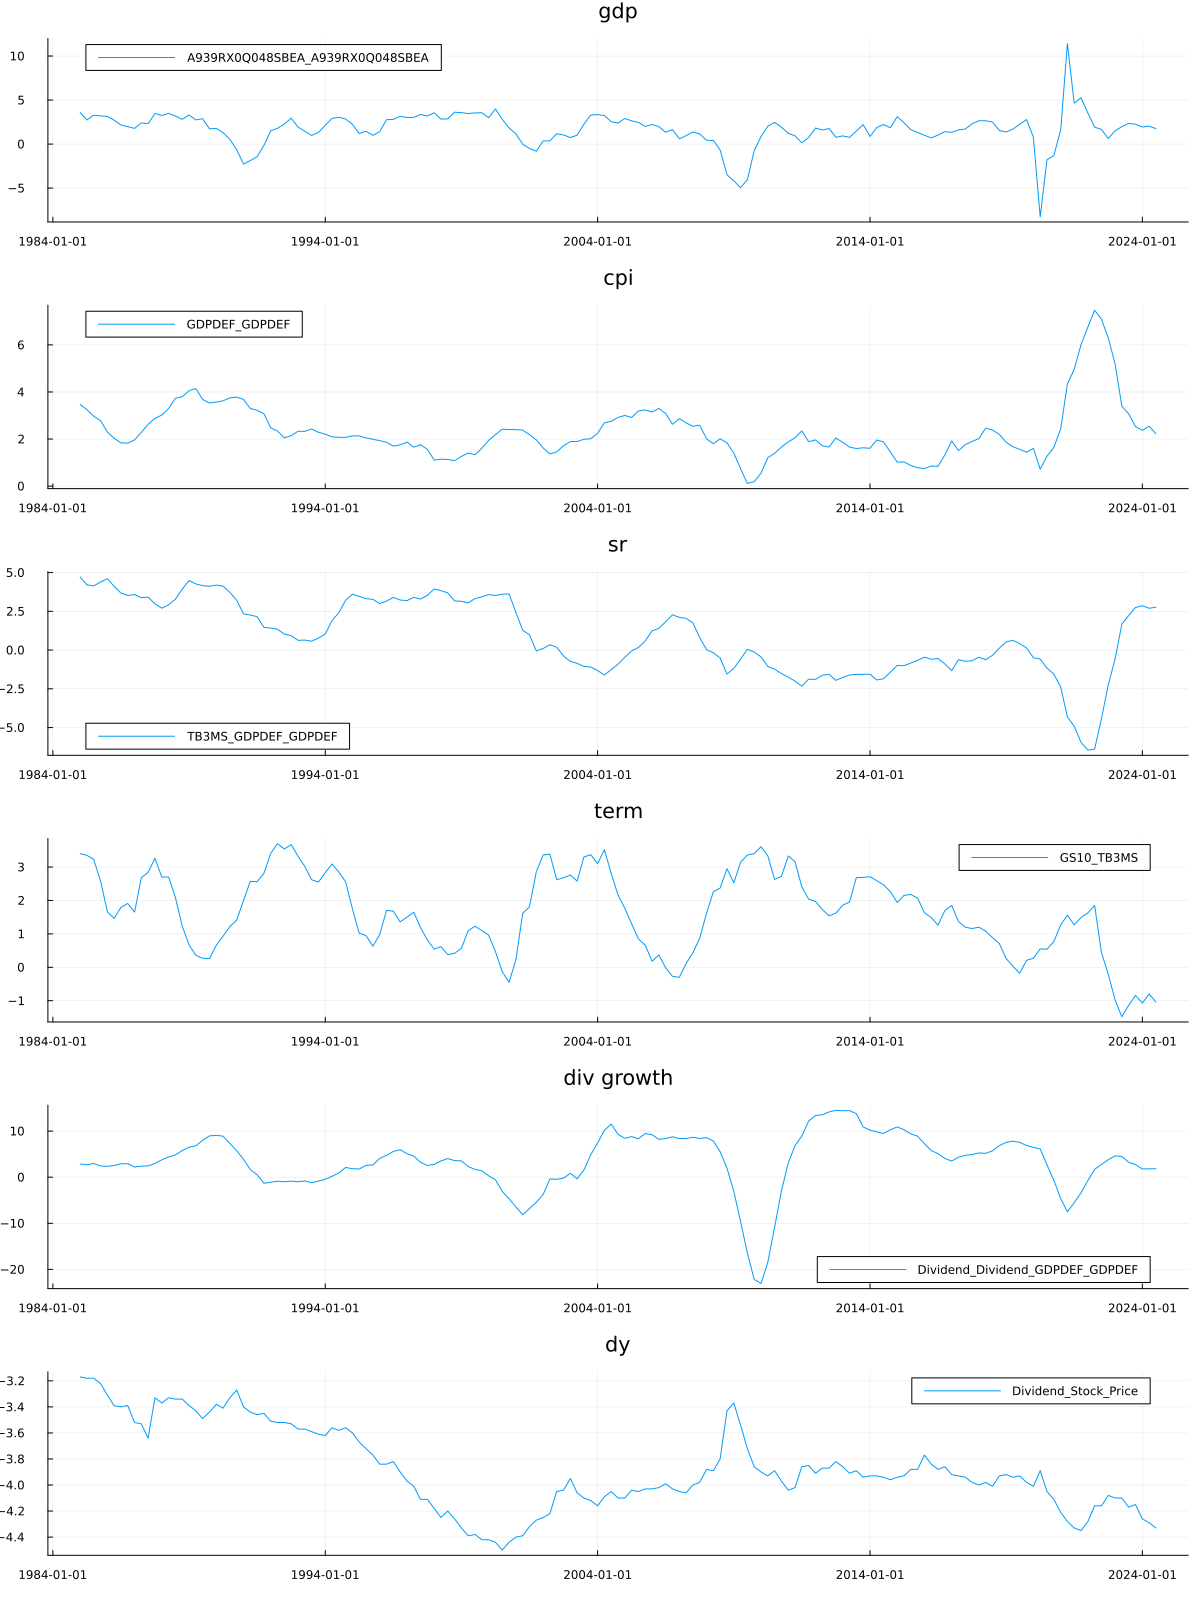

In [50]:
plot(s_data; layout = (6,1), size=(1200,1600), title=["gdp" "cpi" "sr" "term" "div growth" "dy"])

In [51]:
assets_names = colnames(s_data)
T, n_assets = size(s_data)
model = VARModel(s_data)
model_summary(model)

,const,A939RX0Q048SBEA_A939RX0Q048SBEA,GDPDEF_GDPDEF,TB3MS_GDPDEF_GDPDEF,GS10_TB3MS,Dividend_Dividend_GDPDEF_GDPDEF,Dividend_Stock_Price,std
A939RX0Q048SBEA_A939RX0Q048SBEA,-2.297,0.6676,-0.0164,0.0771,0.1442,-0.0103,-0.6766,1.4009
GDPDEF_GDPDEF,0.1404,0.0637,0.9167,-0.0326,0.0106,-0.0117,0.0033,0.3485
TB3MS_GDPDEF_GDPDEF,-0.5543,-0.0142,0.1546,0.986,0.0229,0.0162,-0.0321,0.496
GS10_TB3MS,0.4161,-0.0514,-0.0635,0.004,0.9132,-0.0076,0.0109,0.3981
Dividend_Dividend_GDPDEF_GDPDEF,-2.97,0.4756,0.1439,-0.109,0.3033,0.951,-0.4062,1.6254
Dividend_Stock_Price,-0.4505,-0.0016,0.0179,0.0041,0.0238,0.003,0.9094,0.0663


,A939RX0Q048SBEA_A939RX0Q048SBEA,GDPDEF_GDPDEF,TB3MS_GDPDEF_GDPDEF,GS10_TB3MS,Dividend_Dividend_GDPDEF_GDPDEF,Dividend_Stock_Price
A939RX0Q048SBEA_A939RX0Q048SBEA,1.0,0.4,-0.04,-0.07,0.02,-0.3
GDPDEF_GDPDEF,0.4,1.0,-0.62,0.17,-0.12,-0.05
TB3MS_GDPDEF_GDPDEF,-0.04,-0.62,1.0,-0.51,0.05,-0.17
GS10_TB3MS,-0.07,0.17,-0.51,1.0,0.02,0.17
Dividend_Dividend_GDPDEF_GDPDEF,0.02,-0.12,0.05,0.02,1.0,0.13
Dividend_Stock_Price,-0.3,-0.05,-0.17,0.17,0.13,1.0


In [52]:
freq = 4
scenarios = simulate(model, 25*freq, 10_000)
#periods = [2,6, 16, 26]
periods = [1,5, 15, 25]
ret_in_years = cum_returns_in_periods(scenarios, periods, freq, true)
print_scenarios_summary(ret_in_years, assets_names, string.(periods))

for a in 1:n_assets
    print_scenarios_percentiles(ret_in_years[a, :, :], [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.(periods), string.(assets_names[a]))
end  

,A939RX0Q048SBEA_A939RX0Q048SBEA,GDPDEF_GDPDEF,TB3MS_GDPDEF_GDPDEF,GS10_TB3MS,Dividend_Dividend_GDPDEF_GDPDEF,Dividend_Stock_Price
1,7.4161,8.5841,10.2456,-2.8741,3.3459,-17.4727
5,9.1244,9.2572,6.4324,0.7187,3.7207,-17.6236
15,8.348,9.3647,4.3426,2.7282,11.7055,-17.0347
25,7.8894,9.3352,3.254,3.5033,13.3563,-16.7748


,A939RX0Q048SBEA_A939RX0Q048SBEA,GDPDEF_GDPDEF,TB3MS_GDPDEF_GDPDEF,GS10_TB3MS,Dividend_Dividend_GDPDEF_GDPDEF,Dividend_Stock_Price
1,4.0443,1.3588,1.7166,1.4084,6.1823,0.2412
5,3.0736,2.4891,3.4623,2.8347,13.9729,0.5747
15,2.3237,2.1036,4.058,2.712,11.4741,0.6843
25,2.0138,1.7679,3.739,2.3979,9.9647,0.6358


,A939RX0Q048SBEA_A939RX0Q048SBEA,GDPDEF_GDPDEF,TB3MS_GDPDEF_GDPDEF,GS10_TB3MS,Dividend_Dividend_GDPDEF_GDPDEF,Dividend_Stock_Price
1,-0.0037,0.013,-0.0219,0.0255,-0.0077,0.0092
5,-0.0021,0.0012,-0.0096,-0.0012,-0.0118,0.0093
15,-0.0143,-0.0208,-0.0117,0.0069,0.0542,0.0129
25,-0.0226,-0.0334,-0.0132,0.0244,0.0279,0.0291


,A939RX0Q048SBEA_A939RX0Q048SBEA,GDPDEF_GDPDEF,TB3MS_GDPDEF_GDPDEF,GS10_TB3MS,Dividend_Dividend_GDPDEF_GDPDEF,Dividend_Stock_Price
1,-0.0544,-0.0569,0.0428,0.0123,0.0167,-0.0207
5,0.0054,-0.0451,0.0016,0.0093,0.0616,-0.0181
15,-0.0046,-0.0016,0.0281,-0.0396,-0.0532,0.0642
25,-0.0524,0.0073,-0.0179,-0.0269,-0.0512,0.09


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,-1.8634,-0.5126,0.7791,4.6566,7.4197,10.1669,14.0244,15.3401,16.7918
5,1.8823,3.0914,4.0792,7.0825,9.1078,11.1901,14.1733,15.0834,16.3147
15,2.8802,3.8006,4.5104,6.7823,8.3733,9.8862,12.1591,12.8733,13.8908
25,3.1262,3.881,4.5577,6.5567,7.894,9.2674,11.2018,11.8186,12.5132


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,5.4447,5.957,6.3634,7.6581,8.5679,9.5104,10.8223,11.2774,11.7349
5,3.5091,4.3334,5.1261,7.5803,9.2498,10.9358,13.3509,14.1081,15.0348
15,4.497,5.2129,5.8443,7.965,9.3686,10.7685,12.8192,13.5038,14.3264
25,5.2055,5.8915,6.3997,8.1379,9.3521,10.52,12.2344,12.7682,13.4044


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,6.2435,6.86,7.3662,9.1007,10.2702,11.4062,13.027,13.5748,14.211
5,-1.6229,-0.4458,0.7301,4.1387,6.413,8.7932,12.0927,13.1622,14.5286
15,-5.1114,-3.6285,-2.2442,1.6078,4.3556,7.087,10.9575,12.4246,13.7612
25,-5.6978,-4.0591,-2.8585,0.6388,3.2762,5.7385,9.4887,10.569,11.9695


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,-6.1206,-5.6571,-5.1753,-3.817,-2.8886,-1.922,-0.548,-0.1414,0.409
5,-5.7841,-4.7705,-3.9515,-1.2028,0.729,2.6042,5.3107,6.2343,7.3536
15,-3.5016,-2.5552,-1.7834,0.8956,2.752,4.5465,7.1835,8.0562,8.9475
25,-2.05,-1.1555,-0.4427,1.8923,3.4874,5.1064,7.4804,8.2429,9.0854


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,-11.2069,-8.9454,-6.7905,-0.7457,3.2993,7.5293,13.6379,15.5392,17.6009
5,-29.3679,-24.0301,-19.0794,-5.6901,3.7917,13.1384,26.6523,31.1877,36.2399
15,-14.3787,-10.674,-6.7452,3.8426,11.6619,19.4822,30.6143,34.7168,38.9623
25,-9.3396,-6.072,-2.9807,6.5562,13.2277,20.1004,29.9563,32.8721,37.0428


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,-18.0394,-17.9397,-17.8618,-17.6358,-17.4757,-17.3087,-17.0749,-16.9932,-16.9121
5,-18.9831,-18.7601,-18.5638,-18.0062,-17.6276,-17.2395,-16.6834,-16.4883,-16.264
15,-18.6174,-18.3831,-18.1611,-17.4886,-17.0345,-16.5752,-15.926,-15.6986,-15.4058
25,-18.26,-18.0296,-17.8258,-17.2033,-16.7794,-16.3483,-15.7211,-15.5015,-15.2678


In [409]:
sr = scenarios[2, :,:] + scenarios[3, :,:] 
lr = scenarios[2, :,:] + scenarios[3, :,:] + scenarios[4, :,:] 
real_Δd = scenarios[2, :,:] + scenarios[5, :,:]
dy = exp.(scenarios[6, :,:])



print_scenarios_percentiles(sr[periods, :], [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.(periods), "sr")
print_scenarios_percentiles(lr[periods, :], [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.(periods), "lr")
print_scenarios_percentiles(cumsum(real_Δd, dims=1)[periods,:] ./ (periods.-1), [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.(periods), "Δd")
print_scenarios_percentiles(dy[periods, :], [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.(periods), "dy")



,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,5.23,5.23,5.23,5.23,5.23,5.23,5.23,5.23,5.23
5,-2.9131,-2.1069,-1.3786,0.6713,2.0352,3.4226,5.4366,6.1246,6.8718
15,-3.0421,-2.2088,-1.4642,0.714,2.2166,3.6507,5.7485,6.3823,7.1969
25,-2.841,-2.0352,-1.3719,0.7739,2.2382,3.7379,5.9179,6.5753,7.3594


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,4.16,4.16,4.16,4.16,4.16,4.16,4.16,4.16,4.16
5,0.1776,0.7137,1.1723,2.6384,3.6381,4.6392,6.1148,6.5909,7.0797
15,-0.5195,0.2571,0.851,2.4603,3.6256,4.7479,6.3901,6.875,7.5077
25,-0.3083,0.3566,0.8939,2.5274,3.6907,4.8226,6.4475,6.9968,7.524


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf
5,-5.6531,-4.0022,-2.7898,1.1755,3.9655,6.6786,10.6483,12.0355,13.5775
15,-0.3236,0.6137,1.4427,3.7964,5.329,6.8388,9.1714,9.9154,10.7738
25,1.0137,1.8422,2.4382,4.2376,5.4406,6.6782,8.4154,9.0053,9.711


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,0.0141,0.0141,0.0141,0.0141,0.0141,0.0141,0.0141,0.0141,0.0141
5,0.0082,0.009,0.0098,0.0125,0.015,0.018,0.0232,0.0249,0.0278
15,0.009,0.01,0.0109,0.0143,0.0174,0.0212,0.028,0.0308,0.0339
25,0.0089,0.0099,0.0109,0.0144,0.0175,0.0213,0.0282,0.0308,0.0343


In [ ]:
real_Δd[1,:] .= 1.

div_index =values(data_source[:Dividend][end])[1] .* exp.(cumsum(real_Δd, dims=1) ./100)
price_index = div_index ./ dy
periods = [1, 5, 10, 25] * freq

eq_ret = log.((price_index[2:end,:] .+ div_index[2:end,:] ) ./ price_index[1:end-1,:])
eq_cum_ret = cumsum(eq_ret, dims=1)[periods,:] ./ periods
real_eq_ret = eq_ret .- (scenarios[2, 2:end, :] ./100)
real_eq_cum_ret = cumsum(real_eq_ret, dims=1)[periods,:] ./ periods

print_scenarios_percentiles(eq_cum_ret, [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.([1, 5, 10, 25]), "equity return")
print_scenarios_percentiles(real_eq_cum_ret, [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.([1, 5, 10, 25]), "equity real return")

,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,-0.2474,-0.1989,-0.1551,-0.0049,0.101,0.2046,0.3592,0.4081,0.4644
5,-0.1001,-0.0823,-0.0656,-0.0098,0.0281,0.0656,0.1199,0.1376,0.1615
10,-0.0366,-0.0229,-0.0125,0.0199,0.0436,0.0675,0.101,0.1119,0.124
25,0.0142,0.0217,0.0282,0.048,0.0612,0.0749,0.0945,0.1016,0.1089


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,-0.2737,-0.2224,-0.1785,-0.029,0.0778,0.1812,0.3366,0.3889,0.4414
5,-0.1255,-0.1068,-0.0897,-0.033,0.0058,0.0434,0.0994,0.1173,0.14
10,-0.0619,-0.0491,-0.0377,-0.0033,0.0209,0.0458,0.0799,0.0923,0.103
25,-0.0119,-0.0034,0.0033,0.0242,0.0382,0.0524,0.073,0.0798,0.088


In [411]:
mdd, mddl = max_drawdown_and_length(real_eq_ret)

display("real equity")
display("mdd")
display(quantile(mdd, [.03, .25, .5, .75, .97])')
display("mddl")
display(quantile(mddl, [.03, .25, .5, .75, .97])')

"real equity"

"mdd"

1×5 adjoint(::Vector{Float64}) with eltype Float64:
 0.214233  0.327469  0.402932  0.485421  0.631036

"mddl"

1×5 adjoint(::Vector{Float64}) with eltype Float64:
 4.0  7.0  9.0  13.0  21.0

In [445]:
eq_return = calculate_equity_returns(real_Δd, scenarios[6, :,:])
eq_cum_return = cumsum(eq_return, dims=1)[periods,:] ./ periods

print_scenarios_percentiles(eq_cum_return, [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.([1, 5, 10, 25]), "equity return")

,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,-0.2474,-0.1989,-0.1551,-0.0049,0.101,0.2046,0.3592,0.4081,0.4644
5,-0.1001,-0.0823,-0.0656,-0.0098,0.0281,0.0656,0.1199,0.1376,0.1615
10,-0.0366,-0.0229,-0.0125,0.0199,0.0436,0.0675,0.101,0.1119,0.124
25,0.0142,0.0217,0.0282,0.048,0.0612,0.0749,0.0945,0.1016,0.1089


In [ ]:
percentile(eq_return[1,:], [.25, .5, .75])

In [432]:
bond_returns = calculate_bond_returns(lr./100, 10, 1)
bond_cum_returns = cumsum(eq_ret, dims=1)[periods,:] ./ periods

real_bond_returns = bond_returns .- (scenarios[2, 2:end, :] ./100)
real_bond_cum_returns = cumsum(real_bond_returns, dims=1)[periods,:] ./ periods

print_scenarios_percentiles(bond_cum_returns, [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.([1, 5, 10, 25]), "bonds returns")
print_scenarios_percentiles(real_bond_cum_returns, [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.([1, 5, 10, 25]), "real bonds returns")


mdd, mddl = max_drawdown_and_length(real_bond_returns)

display("real bonds")
display("mdd")
display(quantile(mdd, [.03, .25, .5, .75, .97])')
display("mddl")
display(quantile(mddl, [.03, .25, .5, .75, .97])')


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,-0.2474,-0.1989,-0.1551,-0.0049,0.101,0.2046,0.3592,0.4081,0.4644
5,-0.1001,-0.0823,-0.0656,-0.0098,0.0281,0.0656,0.1199,0.1376,0.1615
10,-0.0366,-0.0229,-0.0125,0.0199,0.0436,0.0675,0.101,0.1119,0.124
25,0.0142,0.0217,0.0282,0.048,0.0612,0.0749,0.0945,0.1016,0.1089


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,-0.1355,-0.1139,-0.0936,-0.0324,0.013,0.0596,0.1342,0.1595,0.1925
5,-0.0236,-0.0153,-0.0087,0.0128,0.0284,0.045,0.0711,0.0801,0.0908
10,-0.0092,-0.0045,-0.0005,0.0121,0.0212,0.0309,0.0453,0.0497,0.0557
25,-0.0021,0.0009,0.0035,0.0112,0.0169,0.0227,0.0307,0.0336,0.0368


"real bonds"

"mdd"

1×5 adjoint(::Vector{Float64}) with eltype Float64:
 0.117724  0.18996  0.247533  0.312757  0.447893

"mddl"

1×5 adjoint(::Vector{Float64}) with eltype Float64:
 5.0  8.0  10.0  14.0  20.0

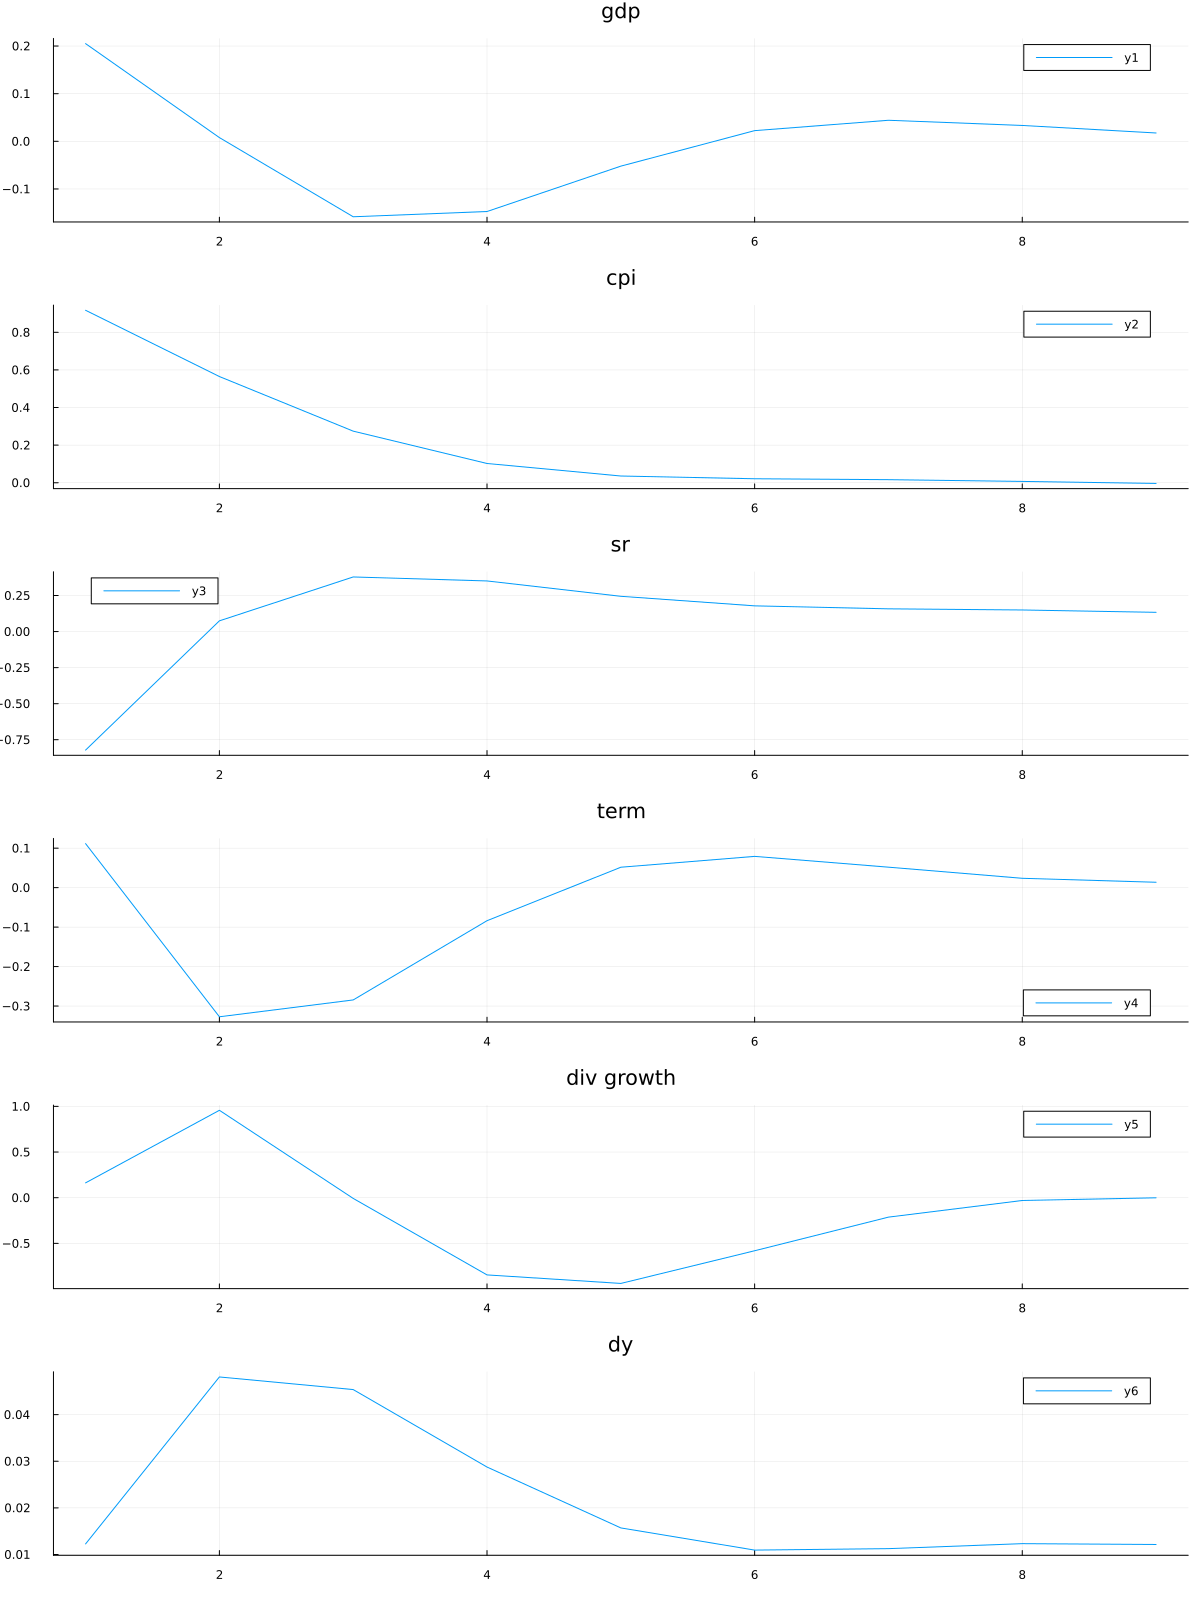

In [394]:
B = collect(model.C[2:end,:]')

resp = girf(B, model.Σ, 8, 2)

plot(resp; layout = (6,1), size=(1200,1600), title=["gdp" "cpi" "sr" "term" "div growth" "dy"])

In [395]:
display(exp(-3.8 ) *100) 
display(exp(-3.8 + 0.08)*100) 
display((exp(-3.8 ) - exp(-3.8 + 0.08))*100) 
display(0.0224*exp((0.06^2)-1)^.5 *100)
display(exp(-4.8 ) *100) 

2.23707718561656

2.4233967845691122

-0.1863195989525522

1.3610764116758998

0.822974704902003

IRF returns
- estimate dy, and div idnex, based on initial value, mean?
- estimate returns?
- 

In [398]:
resp

9×6 Matrix{Float64}:
  0.205032     0.917194    -0.821923    0.111532    0.162595     0.0122668
  0.00782852   0.564811     0.0743009  -0.327101    0.956952     0.0480798
 -0.158327     0.274394     0.378584   -0.284465   -0.00767694   0.0453723
 -0.147278     0.102321     0.35093    -0.0837229  -0.845007     0.0287552
 -0.0520637    0.0357694    0.244463    0.0517411  -0.938294     0.0156982
  0.0224315    0.0211694    0.178242    0.0792233  -0.580497     0.0109419
  0.0441812    0.0163233    0.157597    0.0518588  -0.212467     0.0112553
  0.0332889    0.00703865   0.149632    0.0237021  -0.0302965    0.0123253
  0.0175015   -0.00369872   0.133335    0.0136528  -0.000916989  0.0121455

In [401]:
real_Δd = resp[:,2] + resp[:,5]




9-element Vector{Float64}:
  1.0797892755465686
  1.5217628714764875
  0.2667166582250462
 -0.7426857041307111
 -0.9025246436090105
 -0.5593276034867914
 -0.19614392634112257
 -0.0232578011281097
 -0.0046157094096425395

In [ ]:
dy = exp.(scenarios[6, :,:])